In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/Kaggle/Walmart-M5-Accuracy/Data'

/content/drive/My Drive/Kaggle/Walmart-M5-Accuracy/Data


Kaggle Problem:

https://www.kaggle.com/c/m5-forecasting-accuracy

In [ ]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import regex as re
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
import gc
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
import os

In [ ]:
import pandas as pd
cal = pd.read_csv('./calendar.csv')
stval = pd.read_csv('./sales_train_validation.csv')
price = pd.read_csv('./sell_prices.csv') 

In [ ]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
stval.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [ ]:
price.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [ ]:
print('calender dataset size', cal.shape)
print('sales dataset size', stval.shape)
print('price dataset size', price.shape)

calender dataset size (1969, 14)
sales dataset size (30490, 1919)
price dataset size (6841121, 4)


In [ ]:
# Downcasting

import numpy as np
def reduce_mem_usage(df):
   
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
reduce_mem_usage(stval)

Memory usage of dataframe is 446.40 MB
Memory usage after optimization is: 95.42 MB
Decreased by 78.6%


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,0,3,1,4,1,0,0,3,4,4,0,0,1,0,1,1,7,7,3,6,3,3,7,12,4,2,7,5,12,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,5,0,1,1,3,1,1,0,4,2,0,1,2,1,1,0,0,0,0,3,1,1,1,2,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,2,4,1,8,5,2,7,5,3,5,20,8,10,3,3,4,7,2,3,5,6,3,4,1,2,5,1,2,2,2,...,1,1,2,0,0,2,0,0,0,2,0,1,1,0,0,0,0,1,1,2,1,4,0,0,2,2,4,0,0,0,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,2,1,1,2,4,3,0,0,0,0,0,1,1,2,1,1,1,1,2,0,1,0,3,0,0,1,0,0,1,0,3,1,3


In [ ]:
reduce_mem_usage(cal)

Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.22 MB
Decreased by -5.7%


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
reduce_mem_usage(price)

Memory usage of dataframe is 208.77 MB
Memory usage after optimization is: 45.77 MB
Decreased by 78.1%


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.000000
6841117,WI_3,FOODS_3_827,11618,1.000000
6841118,WI_3,FOODS_3_827,11619,1.000000
6841119,WI_3,FOODS_3_827,11620,1.000000


In [ ]:
stval.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


Melting

melt() function is used to unpivot "sales" dataframe from wide format to long format


In [ ]:
sales = pd.melt(stval, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='demand').dropna()

In [ ]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [ ]:
sales.shape

(58327370, 8)

In [ ]:
# merging with calender DF

sales = sales.merge(cal, left_on='d', right_on='d', how='left')

In [ ]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
# merging with price DF

sales = pd.merge(sales, price, on=['store_id','item_id','wm_yr_wk'], how='left')

In [ ]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


In [ ]:
sales = sales.drop(['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI','wm_yr_wk','weekday'], axis=1)

In [ ]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wday,month,year,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,1,1,2011,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,1,1,2011,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,1,1,2011,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,1,1,2011,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,1,1,2011,NaN


In [ ]:
sales.shape

(58327370, 13)

In [ ]:
len(sales.loc[sales['sell_price'].isna()])/len(sales)

0.2108686367994991

Due to huge size of data and computational constraints , we will work with data for only one food item FOODS_3_555 from location CA_1

In [ ]:
sale_food_ca = sales[sales['id'] == 'FOODS_3_555_CA_1_validation'] 

In [ ]:
len(sale_food_ca.loc[sale_food_ca['demand']==0]), len(sale_food_ca)

(6, 1913)

In [ ]:
sale_food_ca.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wday,month,year,sell_price
2779,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,d_1,23,2011-01-29,1,1,2011,1.480469
33269,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,d_2,16,2011-01-30,2,1,2011,1.480469
63759,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,d_3,14,2011-01-31,3,1,2011,1.480469
94249,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,d_4,10,2011-02-01,4,2,2011,1.480469
124739,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,d_5,17,2011-02-02,5,2,2011,1.480469


In [ ]:
sale_food_ca.shape

(1913, 13)

In [ ]:
del sales, price, cal #free some space

In [ ]:
sale_food_ca.dtypes

id            category
item_id       category
dept_id       category
cat_id        category
store_id      category
state_id      category
d               object
demand           int16
date          category
wday              int8
month             int8
year             int16
sell_price     float16
dtype: object

In [ ]:
sale_food_ca['date'] = pd.to_datetime(sale_food_ca['date'])

In [ ]:
sale_food_ca.dtypes

id                  category
item_id             category
dept_id             category
cat_id              category
store_id            category
state_id            category
d                     object
demand                 int16
date          datetime64[ns]
wday                    int8
month                   int8
year                   int16
sell_price           float16
dtype: object

In [ ]:
sale_food_ca = sale_food_ca.set_index('date')['demand']

In [ ]:
sale_food_ca.head()

date
2011-01-29    23
2011-01-30    16
2011-01-31    14
2011-02-01    10
2011-02-02    17
Name: demand, dtype: int16

Stationarity Check : Augmented Dickey Fuller test

In [ ]:
# Function to check Stationarity

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    #rolstd = pd.rolling_std(timeseries, window=12)
    rolmean = pd.Series(timeseries).rolling(window=30).mean()
    rolstd = pd.Series(timeseries).rolling(window=30).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)



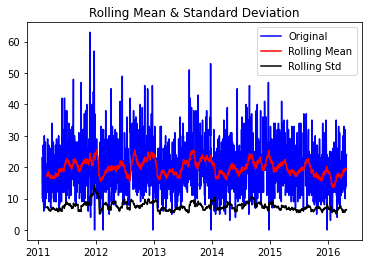

Results of Dickey-Fuller Test:
Test Statistic                -6.166553e+00
p-value                        6.967430e-08
#Lags Used                     2.600000e+01
Number of Observations Used    1.886000e+03
Critical Value (1%)           -3.433822e+00
Critical Value (5%)           -2.863074e+00
Critical Value (10%)          -2.567586e+00
dtype: float64


In [ ]:
test_stationarity(sale_food_ca)

Decision:

Graph shows that the mean value and std deviation of the time series data remain almost unchanged over the period of time.

Thus removal of trend from the data is not required.

The test statistic is smaller than the 1% critical values so we can say with 99% confidence thatthis is a stationary series

Still the p-value is very high so the null hypothesis can not be rejected.

We assume that the data has seasonality thus we will use SARIMA model to train our dataset

In [ ]:
# We require to calculate ACF and PACF as pre-requisite
from statsmodels.tsa.stattools import acf, pacf  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


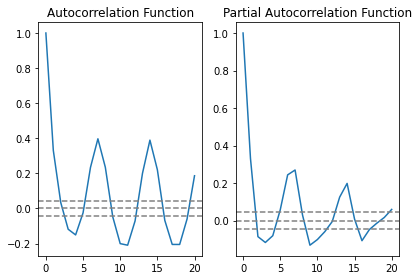

In [ ]:
#ACF and PACF plots for non seasonal data:
from statsmodels.tsa.stattools import acf, pacf  

ns_acf = acf(sale_food_ca, nlags=20)
ns_pacf = pacf(sale_food_ca, nlags=20, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(ns_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(ns_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


Observations:

1. p – The lag value where the PACF chart crosses the upper confidence interval for the first time. In this case the order of p=2.

2. q – The lag value where the ACF chart crosses the upper confidence interval for the first time. In this case the order of q=2.

ACF and PACF plots for seasonal data:

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


<BarContainer object of 30 artists>

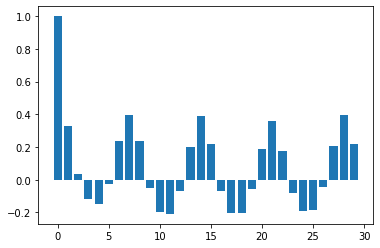

In [ ]:
acf_vals = acf(sale_food_ca)
num_lags = 30
plt.bar(range(num_lags), acf_vals[:num_lags])

Observation:

1.A clear seasonal pattern over a period of 7 days(1 week) has been observed.

2.1st lag is significant

<BarContainer object of 30 artists>

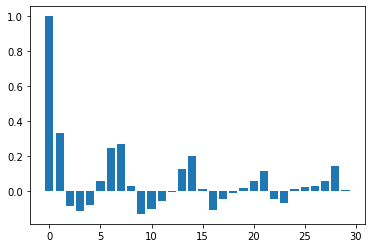

In [ ]:
pacf_vals = pacf(sale_food_ca)
num_lags = 30
plt.bar(range(num_lags), pacf_vals[:num_lags])

Observation:

1.A clear seasonal pattern over a period of 7 days(1 week) has been observed.

2.1st lag is significant

In [ ]:
# Getting training and testing set

train_data = sale_food_ca[:'2016-03-27']
test_data = sale_food_ca['2016-03-28':'2016-04-24']

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
ns_order = (2,0,2)
seasonal_order = (1, 0, 1, 7)
# define model
model = SARIMAX(train_data, order=ns_order, seasonal_order=seasonal_order)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [ ]:
#fit the model

from time import time

start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Model Fitting Time: 4.642328500747681


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
#summary of the model
print(model_fit.summary())

                                 Statespace Model Results                                
Dep. Variable:                            demand   No. Observations:                 1885
Model:             SARIMAX(2, 0, 2)x(1, 0, 1, 7)   Log Likelihood               -6085.402
Date:                           Mon, 11 Jan 2021   AIC                          12184.804
Time:                                   13:12:46   BIC                          12223.596
Sample:                               01-29-2011   HQIC                         12199.090
                                    - 03-27-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7415      0.048     36.216      0.000       1.647       1.836
ar.L2         -0.7427      0.047    -15.897

In [ ]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))

In [ ]:
test_data.head()

date
2016-03-28    19
2016-03-29    19
2016-03-30    16
2016-03-31    12
2016-04-01    19
Name: demand, dtype: int16

In [ ]:
predictions

2016-03-28    15.440344
2016-03-29    13.173202
2016-03-30    13.625328
2016-03-31    14.376547
2016-04-01    17.289184
2016-04-02    23.396440
2016-04-03    24.929680
2016-04-04    15.417821
2016-04-05    13.165585
2016-04-06    13.628580
2016-04-07    14.387828
2016-04-08    17.306181
2016-04-09    23.417277
2016-04-10    24.953634
2016-04-11    15.445094
2016-04-12    13.194820
2016-04-13    13.659028
2016-04-14    14.419097
2016-04-15    17.337792
2016-04-16    23.448718
2016-04-17    24.985199
2016-04-18    15.477747
2016-04-19    13.227772
2016-04-20    13.691952
2016-04-21    14.451919
2016-04-22    17.370267
2016-04-23    23.480511
2016-04-24    25.016737
Freq: D, dtype: float64

In [ ]:
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

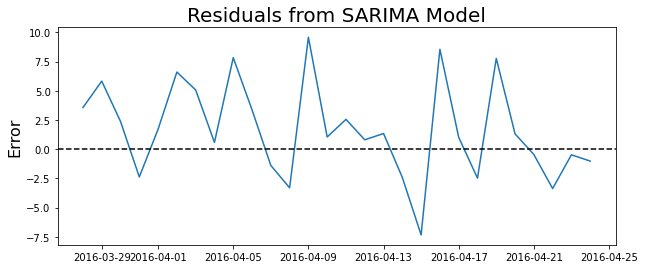

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Production')

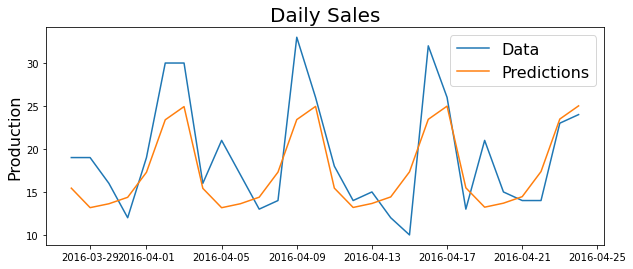

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(sale_food_ca['2016-03-28':'2016-04-24'])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Daily Sales', fontsize=20)
plt.ylabel('Prediction', fontsize=16)

In [ ]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.1827


In [ ]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 4.362684725450202
